In [ ]:
!pip install evaluate --quiet
!pip install emoji --quiet
!pip install transformers



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
train_df = pd.read_csv("train.csv")
test_df =  pd.read_csv("test.csv")

In [ ]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
print(len(train_df))
train_df = train_df.drop_duplicates('text', keep='last')
print(len(train_df))

7613
7503


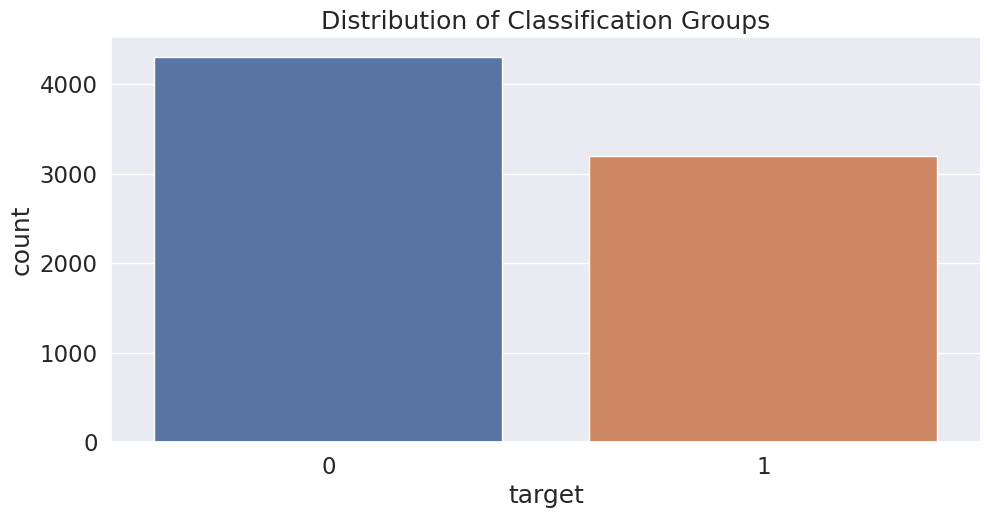

In [ ]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = train_df)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

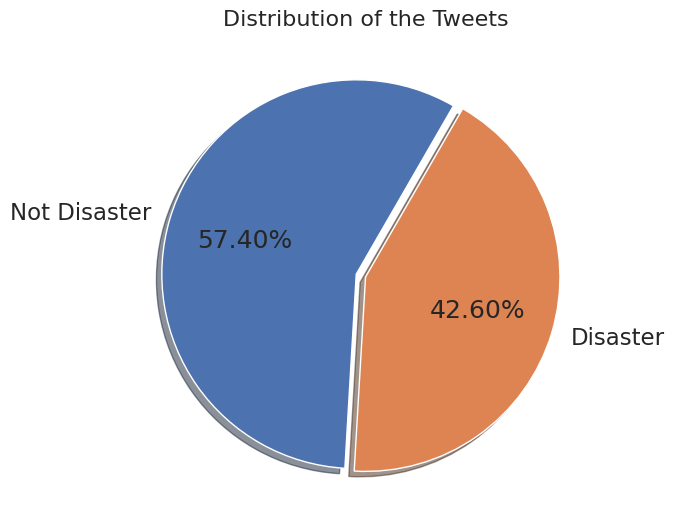

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), dpi=100)
axes.pie(train_df['target'].value_counts(),
          labels=['Not Disaster', 'Disaster'],  # Remove labels
         autopct='%1.2f%%',
         shadow=True,
         explode=(0.05, 0),
         startangle=60)
axes.set_title('Distribution of the Tweets', fontsize=16)

# Remove axes and labels
axes.axis('off')

plt.show()

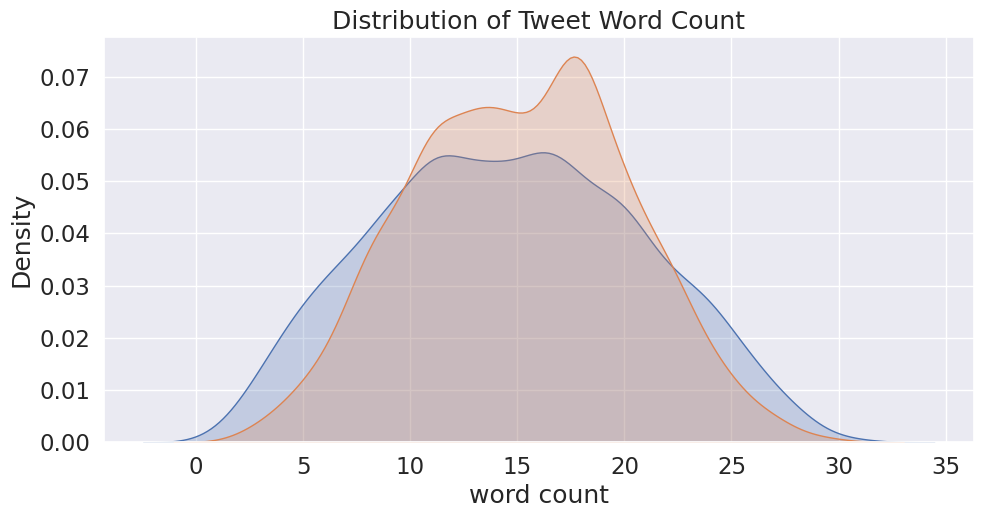

In [ ]:
#create column for the number of words in tweet
train_df['word count'] = train_df['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train = train_df[:len(train_df)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train_df['word count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train_df['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.show()

In [ ]:
train_df['target'].value_counts()

0    4307
1    3196
Name: target, dtype: int64

Unique keywords num=222
Unique keywords num=222


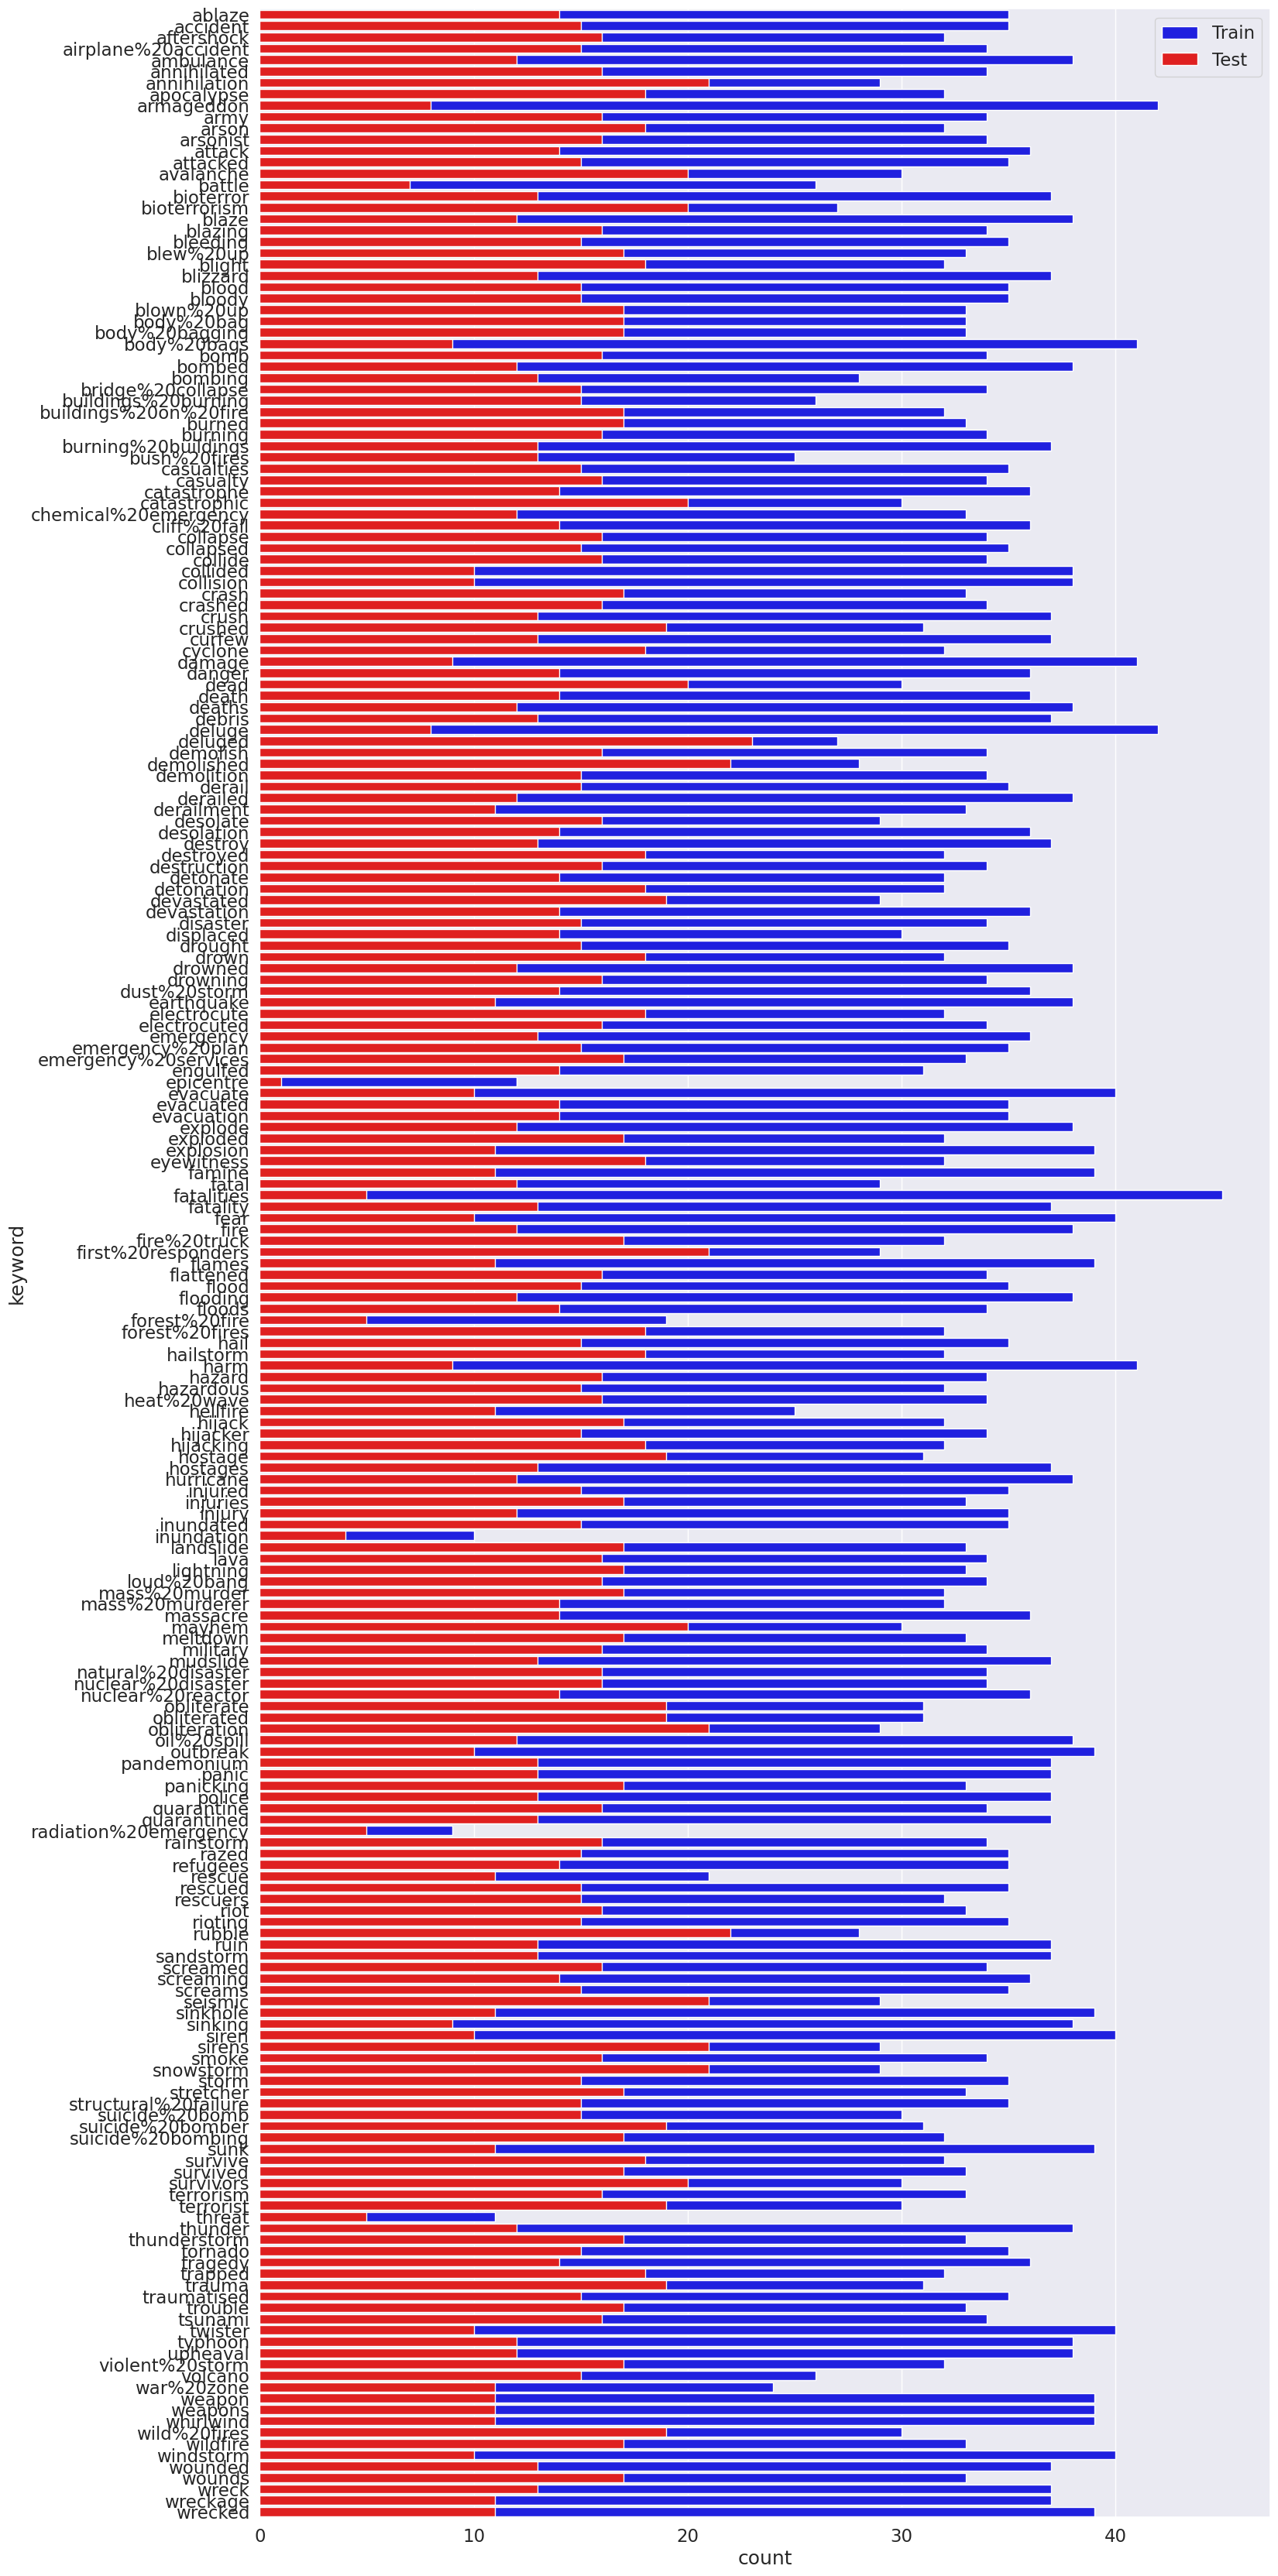

In [ ]:
plt.figure(figsize=(15,40))
print(f'Unique keywords num={len(train_df.keyword.unique())}')
print(f'Unique keywords num={len(test_df.keyword.unique())}')
sns.countplot(y=train_df['keyword'], color=(0,0,1), label='Train')
sns.countplot(y=test_df['keyword'], color=(1,0,0), label='Test')
plt.legend()

<Axes: xlabel='count', ylabel='keyword'>

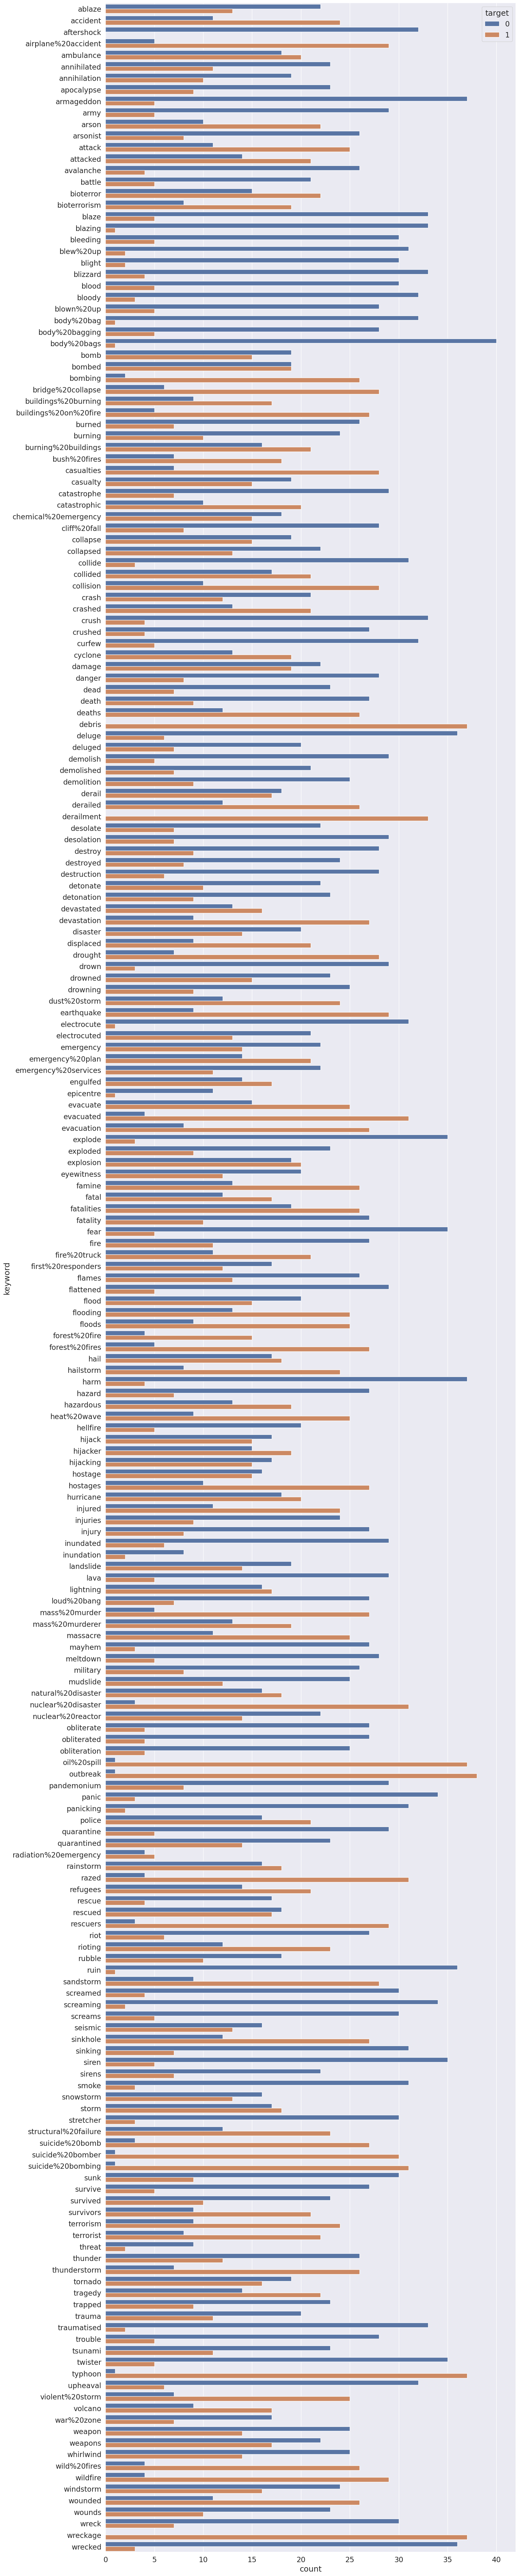

In [ ]:
plt.figure(figsize=(15,100))
sns.countplot(data=train_df, y='keyword', hue='target')

In [ ]:
  def remove_URL(text):
      url = re.compile(r'https?://\S+|www\.\S+')
      return url.sub(r'', text)


  def remove_emoji(text):
      emoji_pattern = re.compile(
          '['
          u'\U0001F600-\U0001F64F'  # emoticons
          u'\U0001F300-\U0001F5FF'  # symbols & pictographs
          u'\U0001F680-\U0001F6FF'  # transport & map symbols
          u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
          u'\U00002702-\U000027B0'
          u'\U000024C2-\U0001F251'
          ']+',
          flags=re.UNICODE)
      return emoji_pattern.sub(r'', text)


  def remove_html(text):
      html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
      return re.sub(html, '', text)


  def remove_punct(text):
      table = str.maketrans('', '', string.punctuation)
      return text.translate(table)

  # Applying helper functions

  train_df['text_clean'] = train_df['text'].apply(lambda x: remove_URL(x))
  train_df['text_clean'] = train_df['text_clean'].apply(lambda x: remove_emoji(x))
  train_df['text_clean'] = train_df['text_clean'].apply(lambda x: remove_html(x))
  train_df['text_clean'] = train_df['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
train_df['tokenized'] = train_df['text_clean'].apply(word_tokenize)

train_df.head()

,id,keyword,location,text,target,word count,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [ ]:
# Lower casing clean text.

train_df['lower'] = train_df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

train_df.head()

,id,keyword,location,text,target,word count,text_clean,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [ ]:
  # Removing stopwords.
stop_words = set(stopwords.words('english'))

train_df['stopwords_removed'] = train_df['lower'].apply(
    lambda x: [word for word in x if word.lower() not in stop_words])

train_df.head()


,id,keyword,location,text,target,word count,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:

train_df['pos_tags'] = train_df['stopwords_removed'].apply(nltk.tag.pos_tag)

train_df.head()

,id,keyword,location,text,target,word count,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


train_df['wordnet_pos'] = train_df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train_df.head()

,id,keyword,location,text,target,word count,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [ ]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

train_df['lemmatized'] = train_df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train_df['lemmatized'] = train_df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train_df['lemma_str'] = [' '.join(map(str, l)) for l in train_df['lemmatized']]

train_df.head()

,id,keyword,location,text,target,word count,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


In [ ]:
lis = [
    train_df[train_df['target'] == 0]['lemma_str'],
    train_df[train_df['target'] == 1]['lemma_str']
]

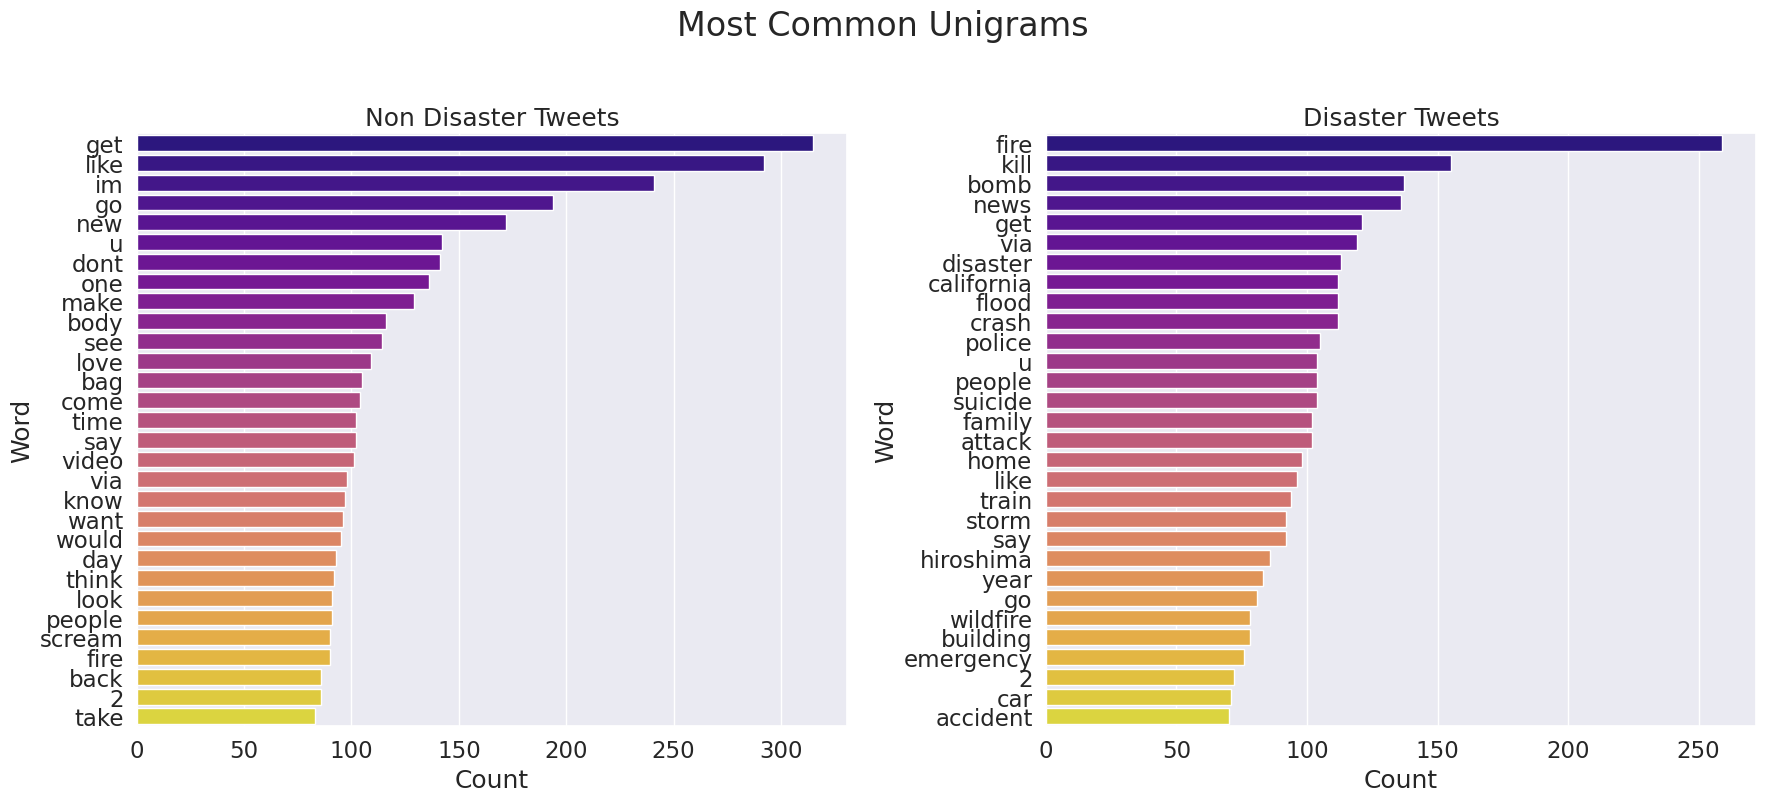

In [ ]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

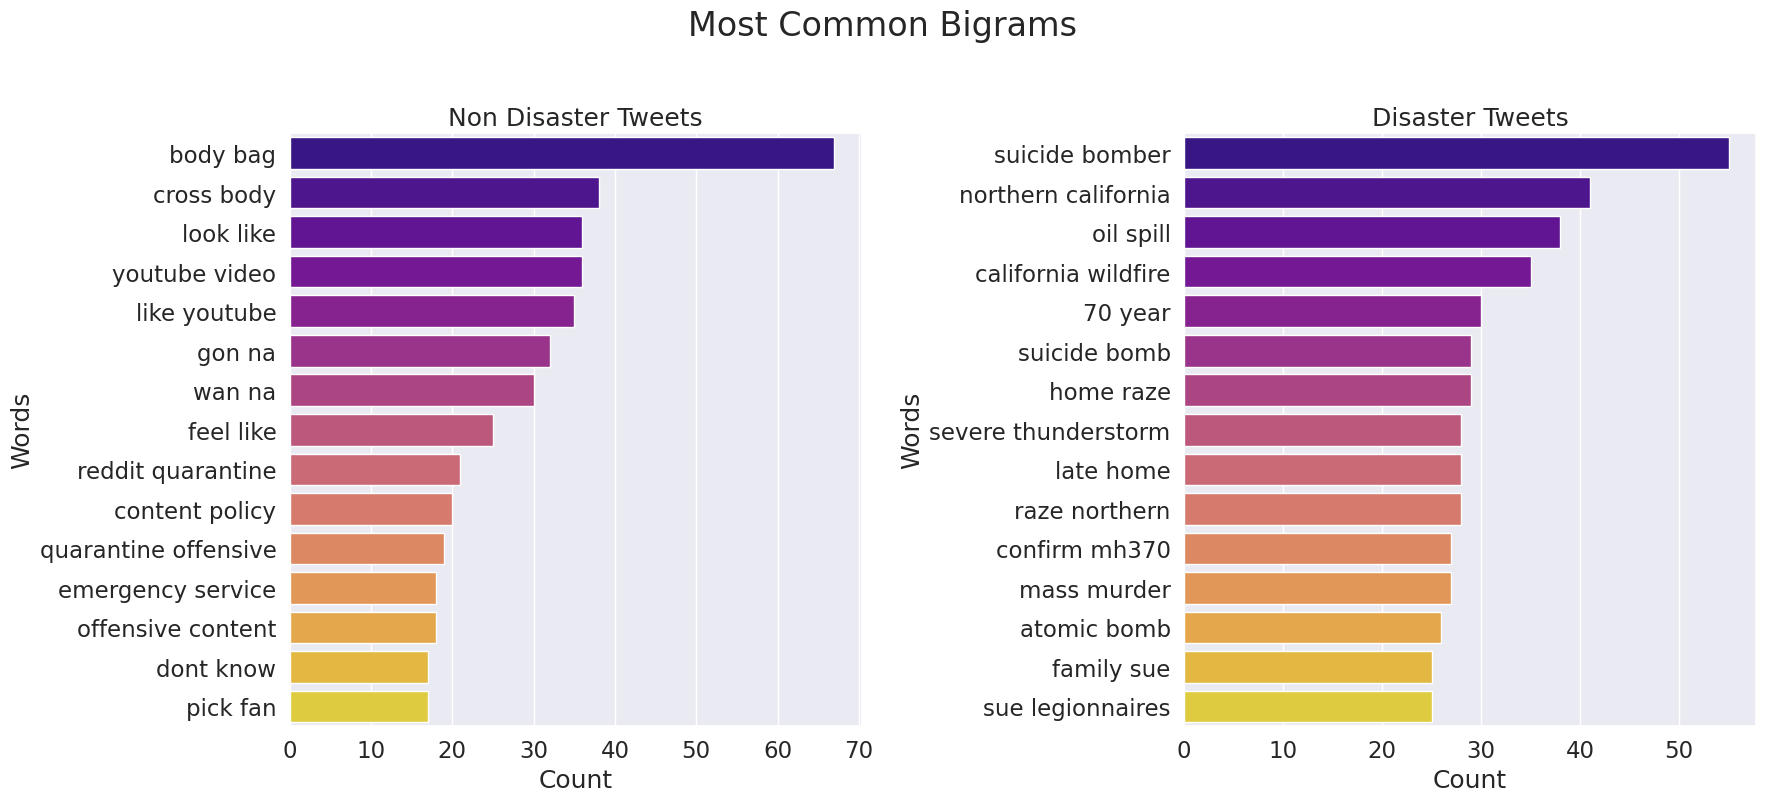

In [ ]:
ngrams(2, 'Most Common Bigrams')

In [ ]:
# If there's a GPU available...

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.

    device = torch.device('cuda')


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Loading the data for modelling.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

Number of training tweets: 7613

Number of training tweets: 3263



In [ ]:
# Setting target variables, creating combined data and saving index for dividing combined data later.

labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

In [ ]:
# Tokenizing the combined text data using bert tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [ ]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [ ]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [ ]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


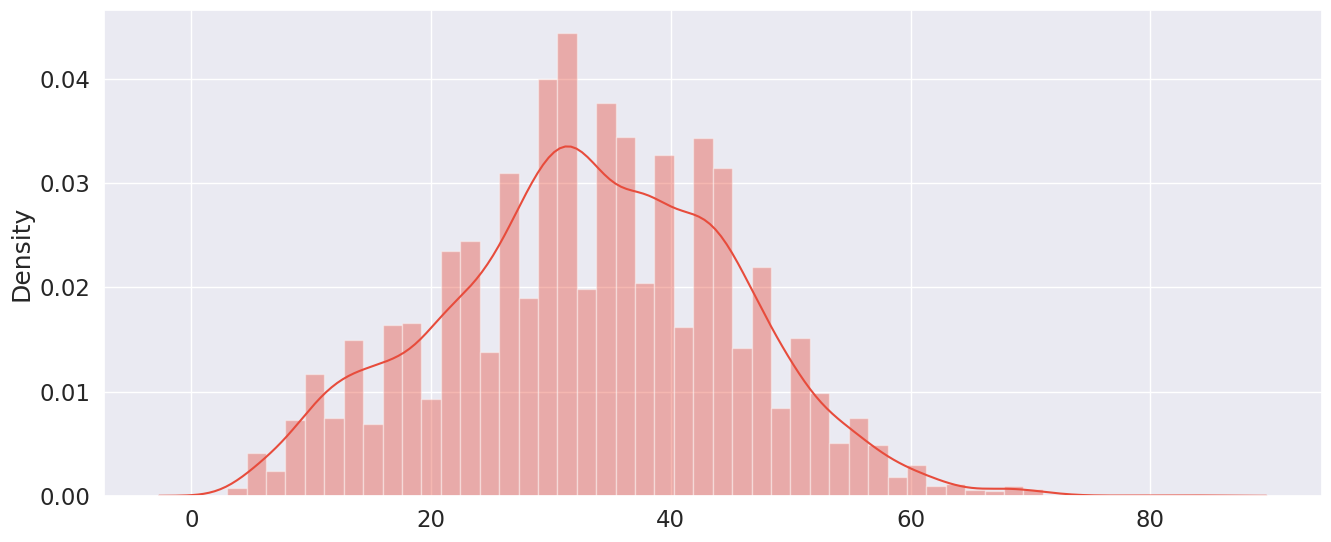

In [ ]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [ ]:
# Splitting the train test data after tokenizing.

train_df= combined[:idx]
test_df = combined[idx:]
train.shape

(7613, 5)

In [ ]:
def tokenize_map(sentence,labs='None'):

    """A function for tokenize all of the sentences and map the tokens to their word IDs."""

    global labels

    input_ids = []
    attention_masks = []

    # For every sentence...

    for text in sentence:
        #   "encode_plus" will:

        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.

        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).

        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
from transformers import BertTokenizer
import torch

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the text
train_texts = list(train_df['text'])
train_inputs = tokenizer(train_texts, padding="max_length", truncation=True, max_length=64, return_tensors="pt")


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Before feeding the data to BERT, create a DataLoader:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

batch_size = 32
train_labels = train_df['target'].values

train_dataset = TensorDataset(train_inputs.input_ids, train_inputs.attention_mask, torch.tensor(train_labels))
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

train_dataset

In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


# Move the model to the device
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

accum_steps = 4
for epoch in range(accum_steps):
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, train_labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad() if step % accum_steps == 0 else None
        output = model(input_ids, attention_mask=attention_mask, labels=train_labels)
        loss = output.loss
        loss.backward()

        if (step + 1) % accum_steps == 0:
            optimizer.step()

In [ ]:
evaluate_text = list(test_df['text'])
evaluate_inputs = tokenizer(evaluate_text, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
evaluate_inputs = {key: val.to(device) for key, val in evaluate_inputs.items()}  # Send the inputs to the same device as model

predictions = []
model.eval()

# Adjusting the DataLoader to use evaluate_inputs instead of train_inputs
for input_ids, attention_mask in DataLoader(TensorDataset(evaluate_inputs['input_ids'], evaluate_inputs['attention_mask']), batch_size=batch_size):
    with torch.no_grad():
        # Send the input tensors to the same device as model
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        output = model(input_ids, attention_mask=attention_mask)
        predictions.extend(torch.argmax(output.logits, axis = 1).tolist())

In [ ]:
test_df["target"] = predictions
submission = test_df[["id", "target"]]
submission.to_csv("submission.csv", index=False)

In [ ]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
def compute_accuracy(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


In [ ]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.eval()  # Set the model to evaluation mode

total_predictions = []
total_labels = []

with torch.no_grad():
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        logits = model(input_ids, attention_mask=attention_mask)[0]
        predictions = torch.argmax(logits, dim=1)

        total_predictions.extend(predictions.tolist())
        total_labels.extend(labels.tolist())

accuracy_a1 = compute_accuracy(torch.tensor(total_predictions), torch.tensor(total_labels))
precision_a1 = precision_score(total_labels, total_predictions, average='binary')  # Change 'binary' based on your class setup
recall_a1 = recall_score(total_labels, total_predictions, average='binary')  # Change 'binary' based on your class setup
f1_a1 = f1_score(total_labels, total_predictions, average='binary')  # Change 'binary' based on your class setup
accuracy1 = accuracy_score(torch.tensor(total_predictions), torch.tensor(total_labels))
print(f"Accuracy: {accuracy_a1:.2f}")
print(f"Precision: {precision_a1:.2f}")
print(f"Recall: {recall_a1:.2f}")
print(f"F1 Score: {f1_a1:.2f}")
print(f"Accuracy: {accuracy_a1:.2f}")
accuracies.append(accuracy_a1)
precisions.append(precision_a1)
recalls.append(recall_a1)
f1_scores.append(f1_a1)


Accuracy: 0.93
Precision: 0.95
Recall: 0.90
F1 Score: 0.92
Accuracy: 0.93


In [ ]:
# train_df.to_csv('/drive/MyDrive/preprocessed/train_df.csv', index=False)


In [ ]:
!pip install -q mlflow nlp 2>/dev/null

In [ ]:
import numpy as np  # Import NumPy for handling numerical operations
import pandas as pd  # Import Pandas for data manipulation and analysis
import warnings  # Import Warnings to suppress unnecessary warnings

# Suppress warning messages
warnings.filterwarnings("ignore")

from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)
import gc
import re
import torch
from transformers import AutoModel, AutoTokenizer
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from nlp import Dataset
from imblearn.over_sampling import RandomOverSampler
import datasets
from transformers import pipeline
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
tqdm.pandas()


In [ ]:
# Set parameters
train_fraction = 0.8  # Fraction of the dataset used for training (the rest used for validation)
num_train_epochs = 20  # Number of epochs to train
batch_size = 64  # Batch size for training and validation
warmup_steps = 50 # Warmup steps
weight_decay = 0.02 # Weight decay
learning_rate = 2e-6 # Learning rate
num_titles = None  # If not None, use a smaller sample of tweets
BERT_MODEL = "distilbert-base-cased" # BERT model to use for training
selected_cols = ['text', 'label']  # Selected columns to combine initial dataframes

In [ ]:
# clean text, see https://stackoverflow.com/a/12982689
# Define a function to clean texts
def clean_text(rawtext):
    # Use BeautifulSoup to remove any HTML tags from the raw text
    cleantext = BeautifulSoup(rawtext, "lxml").text

    # Replace special characters '\u200a' and '\xa0' with spaces for better readability
    cleantext = cleantext.replace('\u200a', '').replace('\xa0', ' ')

    # Return the cleaned text
    return cleantext

In [ ]:
# Read training data
df = pd.read_csv("train.csv")

# Apply a function 'clean_text' to the 'text' column to preprocess it
df['text'] = df['text'].apply(clean_text)

df['label'] = df['target']

# Select only given column and drop duplicates
df = df[selected_cols].drop_duplicates()

# Randomly shuffle the rows in the dataframe to ensure randomness in the data
df = df.sample(frac=1)

# Print the shape of the resulting dataframe to display the number of rows and columns
print(df.shape)

(7521, 2)


In [ ]:
# Calculate the mean (average) of the 'target' column in the DataFrame 'df'.
mean_target = df['label'].mean()
print(mean_target)

0.4262731019811195


In [ ]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'target' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'target' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

34133

In [ ]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Apply the preprocess_function to tokenize the 'text' field in the dataset in batches.
dataset = dataset.map(preprocess_function, batched=True)


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
dataset = dataset.train_test_split(test_size=1-train_fraction)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 6904),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 1726)}

In [ ]:
# Remove the "text" column from the medium_dataset.
# We are removing this text column because it is no longer needed, which helps free up memory.

dataset.remove_column_("text")

# This step is optional but can improve execution speed.
# By removing unnecessary columns, we can make certain operations faster.

In [ ]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the
#  length of the longest element in the batch, making them all the same length.
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Access the 'input_ids' of the first example in the 'train' split of the dataset.
input_ids = dataset['train'][0]['input_ids']

# Decode the 'input_ids' using the tokenizer to obtain the original text.
decoded_text = tokenizer.decode(input_ids)

# Print the decoded text to see the result.
print(decoded_text)

[CLS] @ charlesadler Ian Lee's word is like'A fart in a windstorm '. Such a browner. [SEP]


In [ ]:
# Loading and training model
# We are initializing a model for sequence classification using the pre-trained BERT model.
# - `BERT_MODEL` is the name or path of the BERT model to be loaded.
# - `num_labels=2` specifies that our model will be used for a binary classification task with two labels.
# - `output_attentions=False` indicates that the model won't return attention weights during inference.
# - `output_hidden_states=False` specifies that the model won't return all hidden states.
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Defining label mappings
# We are setting up a mapping from numeric labels (0 and 1) to human-readable class labels.
# In our case, label 0 corresponds to 'NOT ENGAGING TITLE', and label 1 corresponds to 'ENGAGING TITLE'.
model.config.id2label = {0: 'NO DISASTER', 1: 'DISASTER'}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Calculate and print the number of trainable parameters in the model.
# We divide the result by 1e6 to express it in millions for readability.
print(model.num_parameters(only_trainable=True)/1e6)

65.783042


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import tensorflow as tf
import re
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased', do_lower_case=True)
bert_layer = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased', trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
max_len = 175

def encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []

    for i in range(len(texts)):
        encoded = tokenizer.encode_plus(
            texts[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
            truncation=True
        )

        all_tokens.append(encoded['input_ids'])
        all_masks.append(encoded['attention_mask'])

    return np.array(all_tokens).squeeze(), np.array(all_masks).squeeze()


train_inputs = encode(train_df['text'], tokenizer, max_len)
test_inputs = encode(test_df['text'], tokenizer, max_len)

In [ ]:
def build_model(bert, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len, ), dtype=tf.int32, name='input_ids')
    input_mask = tf.keras.Input(shape=(max_len, ), dtype=tf.int32, name='attention_mask')

    output = bert([input_word_ids, input_mask])[0]
    x = layers.Dropout(0.6)(output)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.55)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask], outputs=out)
    model.compile(tf.keras.optimizers.Adam(1e-06), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = build_model(bert_layer, max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 175)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 175)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   1347340   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 175, 768)   80         'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=0.00002
)

In [ ]:
target = train_df.pop('target')
target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
history = model.fit(
    train_inputs,target,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]

)

Epoch 1/10
191/191 [==============================] - 70s 295ms/step - loss: 0.7035 - accuracy: 0.6161 - val_loss: 0.5457 - val_accuracy: 0.7590 - lr: 1.0000e-06
Epoch 2/10
191/191 [==============================] - 53s 277ms/step - loss: 0.6028 - accuracy: 0.6957 - val_loss: 0.5264 - val_accuracy: 0.7702 - lr: 1.0000e-06
Epoch 3/10
191/191 [==============================] - 52s 271ms/step - loss: 0.5731 - accuracy: 0.7187 - val_loss: 0.5113 - val_accuracy: 0.7715 - lr: 1.0000e-06
Epoch 4/10
191/191 [==============================] - 53s 276ms/step - loss: 0.5513 - accuracy: 0.7304 - val_loss: 0.4961 - val_accuracy: 0.7754 - lr: 1.0000e-06
Epoch 5/10
191/191 [==============================] - 52s 270ms/step - loss: 0.5245 - accuracy: 0.7466 - val_loss: 0.4875 - val_accuracy: 0.7827 - lr: 1.0000e-06
Epoch 6/10
191/191 [==============================] - 53s 276ms/step - loss: 0.5189 - accuracy: 0.7517 - val_loss: 0.4827 - val_accuracy: 0.7866 - lr: 1.0000e-06
Epoch 7/10
191/191 [========

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have predictions and true labels
test_target=test_df['target']
predictions = model.predict(test_inputs)
predictions = (predictions > 0.5).astype(int)  # Assuming binary classification, adjust as needed
true_labels = test_target.values  # Assuming true labels are in a Pandas Series

# Calculate metrics
accuracy_a2 = accuracy_score(true_labels, predictions)
precision_a2 = precision_score(true_labels, predictions)
recall_a2 = recall_score(true_labels, predictions)
f1_a2 = f1_score(true_labels, predictions)

print(f"Accuracy: {accuracy_a2:.2f}")
print(f"Precision: {precision_a2:.2f}")
print(f"Recall: {recall_a2:.2f}")
print(f"F1 Score: {f1_a2:.2f}")
accuracies.append(accuracy_a2)
precisions.append(precision_a2)
recalls.append(recall_a2)
f1_scores.append(f1_a2)

102/102 [==============================] - 21s 189ms/step
Accuracy: 0.82
Precision: 0.83
Recall: 0.69
F1 Score: 0.76


<Axes: title={'center': 'accuracy'}>

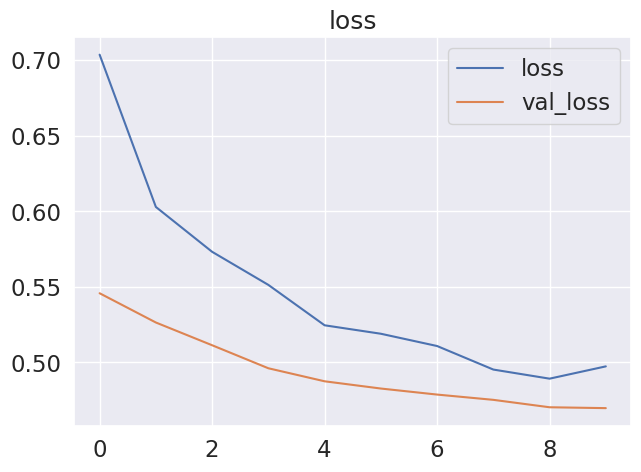

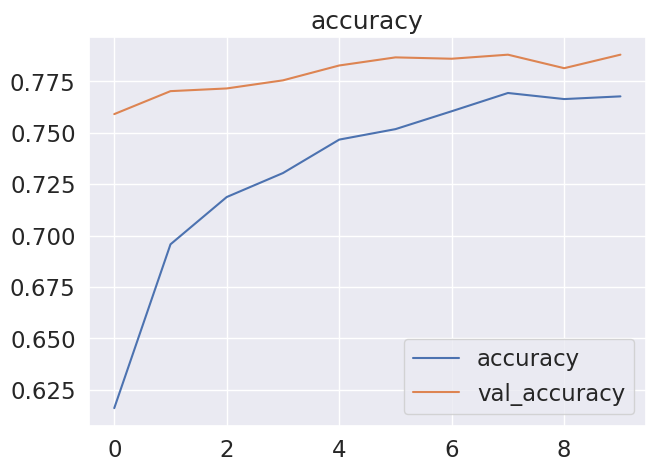

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot(title='loss')
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='accuracy')

In [ ]:
import tensorflow as tf
import string, re
import gensim.downloader as api

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [ ]:
print(tf.version.VERSION)

2.14.0


In [ ]:
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Clear html
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Clear urls


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# Clear special characters


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def clean_df(df):
    # Lowering
    df["text"] = df["text"].apply(lambda x: x.lower())

    # Apply text cleaning
    df["text"] = df["text"].apply(lambda x: remove_emoji(x))
    df["text"] = df["text"].apply(lambda x: remove_html(x))
    df["text"] = df["text"].apply(lambda x: remove_URL(x))
    df["text"] = df["text"].apply(lambda x: remove_punct(x))

    # Remove multiple spaces
    df["text"] = df.text.replace("\s+", " ", regex=True)

    return df


def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = remove_emoji(sentence)
    sentence = remove_html(sentence)
    sentence = remove_punct(sentence)
    sentence = remove_URL(sentence)
    sentence = sentence.replace("\s+", " ", regex=True)

    return sentence

In [ ]:
df = clean_df(df)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['text'].tolist(),
    df['target'].tolist(),
    train_size = .8,
    test_size = .2,
    shuffle = True,
    random_state = 42
)

In [ ]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

6090 6090
1523 1523


In [ ]:
example = X_train[0]
label = y_train[0]

print(example, label)

courageous and honest analysis of need to use atomic bomb in 1945 hiroshima70 japanese military refused surrender  1


In [ ]:
sequence_length = 30
VOCAB_SIZE = 10000
pad_to_max_token = True
embedding_trainable = True
dropout_rate = .5
filters = [1, 2, 3]
num_filters = 200
classification_threshold = .5
learning_rate = 1e-4
# l2_regularization = 3
recurrent_units = 512

epochs = 100
validation_steps = 30
early_stopping_patience = 5

In [ ]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=sequence_length,
    pad_to_max_tokens=pad_to_max_token,
)
encoder.adapt(X_train)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'i', 'and', 'is', 'for',
       'on', 'you', 'my', 'with', 'that', 'it', 'at', 'by', 'this'],
      dtype='<U49')

In [ ]:
vocab.shape

(10000,)

In [ ]:
encoded_example = encoder(X_train)[:3].numpy()
encoded_example

array([[   1,    8, 4916, 2909,    6,  156,    5,  438,  216,  118,    4,
        2374, 4927, 1178,  240, 4363, 4101,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [5860,    1, 6055,  824,    3, 1488,   46,   15, 2717, 5408, 2883,
         373,    4,  183,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 590, 3757,    5, 8344, 4670,    6,    1, 1935,    5,   69, 1350,
          17,    2,  388,    6,  406, 1902, 1064,   50,   33,  113,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
encoded_example.shape

(3, 30)

In [ ]:
sequence_length

30

In [ ]:
for n in range(3):
  print("Original: ", X_train[n])
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  courageous and honest analysis of need to use atomic bomb in 1945 hiroshima70 japanese military refused surrender 
Round-trip:  [UNK] and honest analysis of need to use atomic bomb in 1945 hiroshima70 japanese military refused surrender             

Original:  zachzaidman 670thescore wld b a shame if that golf cart became engulfed in flames boycottbears
Round-trip:  zachzaidman [UNK] wld b a shame if that golf cart became engulfed in flames [UNK]               

Original:  tell barackobama to rescind medals of honor given to us soldiers at the massacre of wounded knee sign now amp rt 
Round-trip:  tell barackobama to rescind medals of [UNK] given to us soldiers at the massacre of wounded knee sign now amp rt         



In [ ]:
pretrain_embedding_name = "glove-twitter-200"

In [ ]:
embedding_model = api.load(pretrain_embedding_name)

In [ ]:
embedding_dimension = embedding_model.vector_size

In [ ]:
embedding_dimension

200

In [ ]:
embedding_matrix = np.zeros((len(encoder.get_vocabulary()), embedding_dimension))

for i, word in enumerate(encoder.get_vocabulary()):
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.49349999,  0.35698   ,  0.66068   , ...,  0.17705999,
        -0.53694999, -0.29699001],
       ...,
       [-0.15188999,  0.29028001,  0.62748998, ...,  0.46028   ,
         0.078022  , -0.15649   ],
       [ 0.61001998, -0.094395  ,  0.034457  , ..., -0.13367   ,
        -0.28351   , -0.11238   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
embedding_matrix.shape

(10000, 200)

In [ ]:
class CNN_RNN_for_Text_Classification(tf.keras.Model):
    def __init__(self,
                 encoder=None,
                 filters=[3, 4, 5],
                 num_filters=100,
                 embedding_dim=300,
                 embedding_weights=None,
                 embedding_trainable=True,
                 recurrent_units=512,
                 recurrent_type="lstm",
                 sequence_length=100,
                 dropout_rate=.5):
        super().__init__()

        self.encoder = encoder
        self.filters = filters
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.dropout_rate = dropout_rate
        self.embedding_weights = embedding_weights
        self.embedding_trainable = embedding_trainable
        self.recurrent_units = recurrent_units
        self.recurrent_type = recurrent_type

        if self.embedding_weights is not None:
            self.embedding = tf.keras.layers.Embedding(
                input_dim=len(self.encoder.get_vocabulary()),
                output_dim=self.embedding_dim,
                input_length=self.sequence_length,
                weights=[self.embedding_weights],
                trainable=self.embedding_trainable,
                name="embedding"
            )

        else:
            self.embedding = tf.keras.layers.Embedding(
                input_dim=len(self.encoder.get_vocabulary()),
                output_dim=self.embedding_dim,
                input_length=self.sequence_length,
                trainable=self.embedding_trainable,
                name="embedding"
            )

        self.reshape = tf.keras.layers.Reshape(
            (self.sequence_length, self.embedding_dim, 1)
        )

        self.convo = [tf.keras.layers.Conv2D(
            filters=self.num_filters,
            kernel_size=(i, self.embedding_dim),
            activation="relu",
        ) for i in self.filters]

        self.max_pooling = [tf.keras.layers.MaxPooling2D(
            pool_size=(self.sequence_length - i + 1, 1),
            strides=(1, 1),
            padding="valid"
        ) for i in self.filters]

        self.concat_cnn = tf.keras.layers.Concatenate(axis=1)

        self.flatten = tf.keras.layers.Flatten()

        if self.recurrent_type == "lstm":
            self.recurrent = tf.keras.layers.LSTM(
                units=self.recurrent_units,
                return_state=True,
            )

        elif self.recurrent_type == "gru":
            self.recurrent = tf.keras.layers.GRU(
                units=self.recurrent_units,
                return_state=True,
            )

        self.concat_cnn_rnn = tf.keras.layers.Concatenate(axis=1)

        self.dense = tf.keras.layers.Dense(64, activation="relu")

        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

        self.final = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, x):
        x = self.encoder(x)

        x = self.embedding(x)

        x_cnn = self.reshape(x)

        # CNN

        convo_output = [layer(x_cnn) for layer in self.convo]

        maxpool_output = [self.max_pooling[i](convo_output[i]) for i in range(len(self.filters))]

        concat_cnn = self.concat_cnn(maxpool_output)

        flatten_cnn = self.flatten(concat_cnn)

        # RNN

        if self.recurrent_type == "lstm":
            recurrent_output, state_h, _ = self.recurrent(x)
        elif self.recurrent_type == "gru":
            recurrent_output, state = self.recurrent(x)

        # Concat

        concat_cnn_rnn = self.concat_cnn_rnn([flatten_cnn, recurrent_output])

        dense = self.dense(concat_cnn_rnn)

        dropout = self.dropout(dense)

        final = self.final(dropout)

        return final

In [ ]:
model = CNN_RNN_for_Text_Classification(encoder=encoder,
                                        num_filters=num_filters,
                                        filters=filters,
                                        embedding_dim=embedding_dimension,
                                        embedding_weights=embedding_matrix,
                                        embedding_trainable=embedding_trainable,
                                        recurrent_units=recurrent_units,
                                        sequence_length=sequence_length,
                                        dropout_rate=dropout_rate)

In [ ]:
print([layer.supports_masking for layer in model.layers])
# y_true = [layer.supports_masking for layer in model.layers]


[False, False, False, False, False, False, False, False, False, True, False, True, True, True, True, True]


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=early_stopping_patience
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=["accuracy"])

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
dataset_val = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
history = model.fit(dataset_train, epochs=epochs,
                    validation_data=dataset_val,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping]
                   )

Epoch 1/100
96/96 [==============================] - 14s 91ms/step - loss: 0.5631 - accuracy: 0.7325 - val_loss: 0.4476 - val_accuracy: 0.8115
Epoch 2/100
96/96 [==============================] - 2s 19ms/step - loss: 0.4331 - accuracy: 0.8117 - val_loss: 0.4328 - val_accuracy: 0.8062
Epoch 3/100
96/96 [==============================] - 2s 19ms/step - loss: 0.4016 - accuracy: 0.8281 - val_loss: 0.4231 - val_accuracy: 0.8208
Epoch 4/100
96/96 [==============================] - 2s 18ms/step - loss: 0.3793 - accuracy: 0.8404 - val_loss: 0.4230 - val_accuracy: 0.8208
Epoch 5/100
96/96 [==============================] - 2s 18ms/step - loss: 0.3568 - accuracy: 0.8530 - val_loss: 0.4206 - val_accuracy: 0.8250
Epoch 6/100
96/96 [==============================] - 1s 15ms/step - loss: 0.3346 - accuracy: 0.8642 - val_loss: 0.4250 - val_accuracy: 0.8219
Epoch 7/100
96/96 [==============================] - 1s 16ms/step - loss: 0.3097 - accuracy: 0.8759 - val_loss: 0.4307 - val_accuracy: 0.8177
Epoch

In [ ]:
model.summary()

Model: "cnn_rnn_for__text__classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  multiple                  0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       multiple                  2000000   
                                                                 
 reshape_1 (Reshape)         multiple                  0         
                                                                 
 conv2d_3 (Conv2D)           multiple                  40200     
                                                                 
 conv2d_4 (Conv2D)           multiple                  80200     
                                                                 
 conv2d_5 (Conv2D)           multiple                  120200    
                               

In [ ]:
#TESTING
test_loss, test_acc = model.evaluate(dataset_val)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

48/48 [==============================] - 0s 7ms/step - loss: 0.4517 - accuracy: 0.8050
Test Loss: 0.4517454504966736
Test Accuracy: 0.8049901723861694


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.5797363847494126)

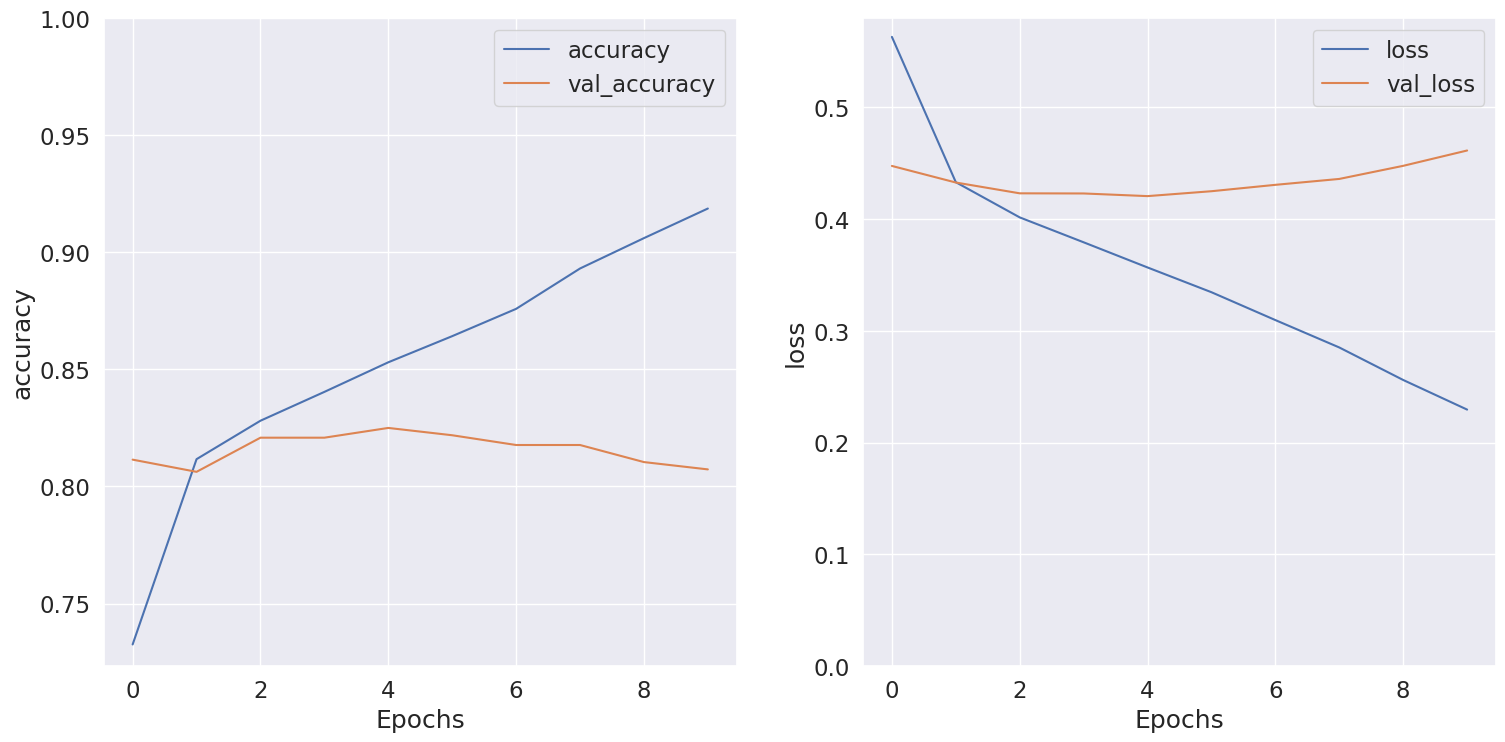

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
test_df = pd.read_csv('test.csv')

test_df = clean_df(test_df)

X_submit = test_df['text'].tolist()

In [ ]:
def create_submission(X_submit, model, threshold=0):
    submission_file = "submission.csv"

    y_pred = model.predict(X_submit)

    i = [x for x in range(len(y_pred))]
    plt.scatter(i, y_pred)
    plt.plot()

    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0

    y_pred = [int(i[0]) for i in y_pred]

    submission_df = pd.DataFrame({
        'id' : test_df['id'].tolist(),
        'target' : y_pred
    })

    submission_df.to_csv(submission_file, index = False)

    return submission_df


102/102 [==============================] - 1s 6ms/step


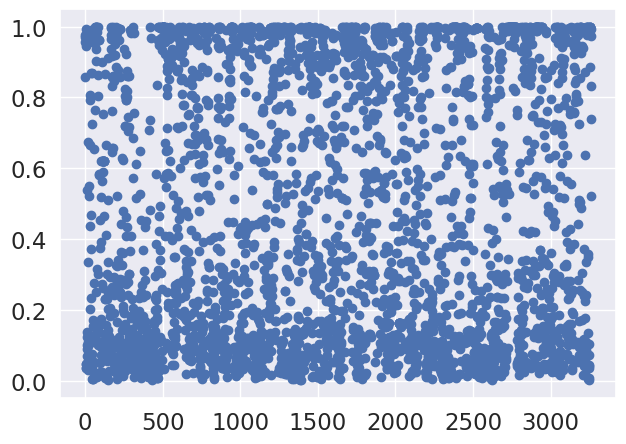

In [ ]:
submission_df = create_submission(X_submit=X_submit,
                                  model=model,
                                 threshold=classification_threshold)

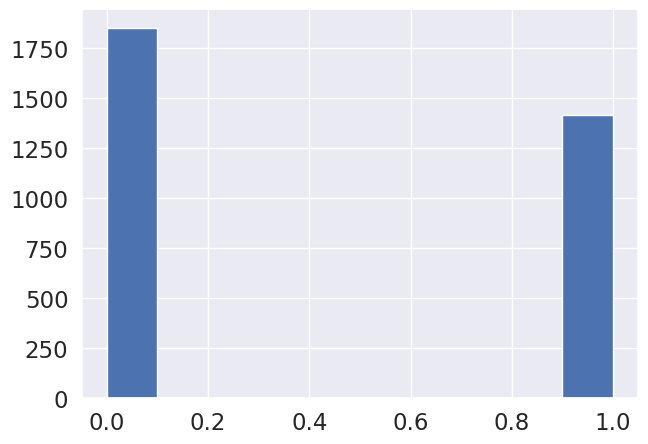

In [ ]:
submission_df["target"].hist()
plt.show()

In [ ]:
print("Number of samples in X_val:", len(dataset_val))
# print("Number of samples in y_val_true:", len(y_val_true))

Number of samples in X_val: 48


In [ ]:
 mfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Assuming you have `X_test` as your test data and `y_true` as your true labels
# Use the model to predict on the test data
predictions = model.predict(dataset_val)  # Assuming `dataset_val` is your validation dataset

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)
# test_df = pd.read_csv('test.csv')
# y_true = test_df["target"]
# y_true = [0,0,0,0,0,0,0,0,0,1,0,1,1,1, 1, 1]
# Calculate accuracy
accuracy_a3 = accuracy_score(y_test, binary_predictions)

# Calculate precision
precision_a3 = precision_score(y_test, binary_predictions)

# Calculate recall
recall_a3 = recall_score(y_test, binary_predictions)

# Calculate F1 score
f1_a3 = f1_score(y_test, binary_predictions)

# Print the metrics
print("Accuracy:", accuracy_a3)
print("Precision:", precision_a3)
print("Recall:", recall_a3)
print("F1 Score:", f1_a3)
print("Length of y_true:", len(y_test))
print("Length of binary_predictions:", len(binary_predictions))
accuracies.append(accuracy_a3)
precisions.append(precision_a3)
recalls.append(recall_a3)
f1_scores.append(f1_a3)


48/48 [==============================] - 1s 6ms/step
Accuracy: 0.8049901510177282
Precision: 0.7611275964391692
Recall: 0.7904468412942989
F1 Score: 0.7755102040816325
Length of y_true: 1523
Length of binary_predictions: 1523


In [ ]:
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


# New Section

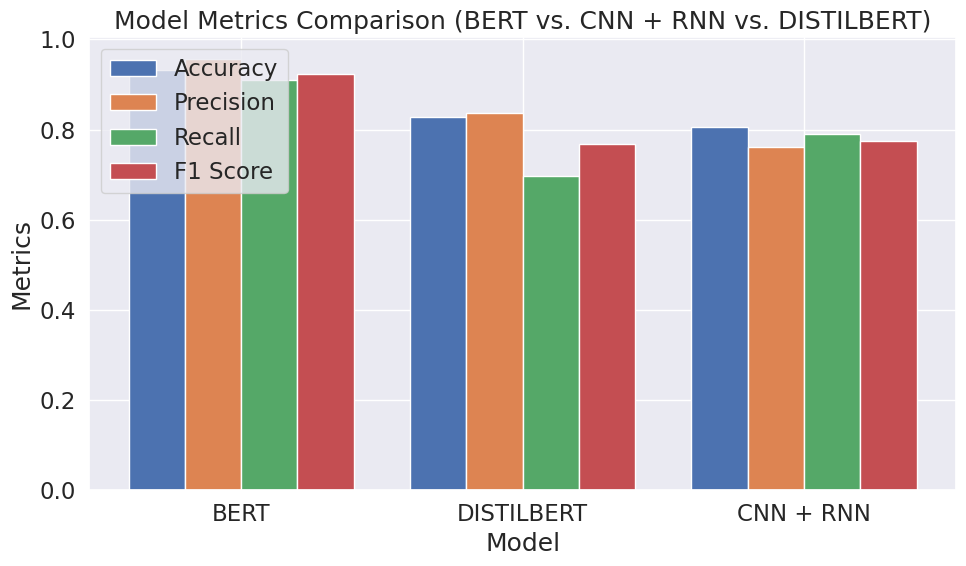

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for BERT, CNN + RNN, and another BERT instance
model_names = ["BERT", "DISTILBERT","CNN + RNN"]
accuracies = [ 0.931789257, 0.828923465 , 0.8049901510]
precisions = [0.95679821, 0.837893451,0.7611275964 ]
recalls = [0.908956153, 0.696423192, 0.790446841]
f1_scores = [0.92367833, 0.76892378,0.7755102040 ]


# Create a grouped bar chart to compare metrics
width = 0.2
x = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * width, accuracies, width, label='Accuracy')
ax.bar(x - 0.5 * width, precisions, width, label='Precision')
ax.bar(x + 0.5 * width, recalls, width, label='Recall')
ax.bar(x + 1.5 * width, f1_scores, width, label='F1 Score')

ax.set_xlabel("Model")
ax.set_ylabel("Metrics")
ax.set_title("Model Metrics Comparison (BERT vs. CNN + RNN vs. DISTILBERT)")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()
